<a href="https://colab.research.google.com/github/Nawel-Bellil/Les-files-d-attentes-MM1-GM1-MG1/blob/main/code/mg1_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from tqdm import tqdm
import seaborn as sns

In [3]:


class MG1Simulator:
    """
    M/G/1 Queue Simulator
    - M: Poisson arrivals (exponential inter-arrival times)
    - G: General service time distribution (Gamma distribution)
    - 1: Single server
    """

    def __init__(self, lambda_rate, mu_rate, shape=2.0, num_customers=2000000, seed=42):
        """
        Initialize M/G/1 simulator

        Args:
            lambda_rate (float): Arrival rate (λ)
            mu_rate (float): Service rate (μ)
            shape (float): Shape parameter for Gamma distribution
            num_customers (int): Number of customers to simulate
            seed (int): Random seed
        """
        if lambda_rate <= 0 or mu_rate <= 0:
            raise ValueError("Arrival and service rates must be positive")
        if lambda_rate >= mu_rate:
            print(f"Warning: λ={lambda_rate} >= μ={mu_rate}, system may be unstable")

        self.lambda_rate = lambda_rate
        self.mu_rate = mu_rate
        self.shape = shape
        self.num_customers = num_customers
        self.rng = np.random.RandomState(seed)

        # Gamma scale parameter: E[S] = shape * scale = 1/μ
        self.scale = 1.0 / (mu_rate * shape)

        # Results storage
        self.waiting_times = np.zeros(num_customers)
        self.response_times = np.zeros(num_customers)
        self.service_times = np.zeros(num_customers)
        self.server_busy_time = 0
        self.total_simulation_time = 0

    def generate_interarrival_time(self):
        """Generate exponential inter-arrival time"""
        return self.rng.exponential(scale=1/self.lambda_rate)

    def generate_service_time(self):
        """Generate Gamma service time"""
        return self.rng.gamma(shape=self.shape, scale=self.scale)

    def run_simulation(self):
        """Run the M/G/1 simulation using event-driven approach"""
        print(f"Starting M/G/1 simulation with {self.num_customers} customers...")

        # Generate all inter-arrival times
        inter_arrival_times = np.array([self.generate_interarrival_time()
                                      for _ in range(self.num_customers)])

        # Generate all service times
        service_times = np.array([self.generate_service_time()
                                for _ in range(self.num_customers)])

        # Calculate arrival times
        arrival_times = np.cumsum(inter_arrival_times)

        # Initialize simulation
        departure_times = np.zeros(self.num_customers)
        current_departure_time = 0

        print("Processing customers...")
        for i in tqdm(range(self.num_customers)):
            arrival_time = arrival_times[i]
            service_time = service_times[i]

            # Calculate waiting time and departure time
            if arrival_time >= current_departure_time:
                # Server is free
                waiting_time = 0
                departure_time = arrival_time + service_time
            else:
                # Server is busy, customer must wait
                waiting_time = current_departure_time - arrival_time
                departure_time = current_departure_time + service_time

            # Update current departure time
            current_departure_time = departure_time

            # Store results
            self.waiting_times[i] = waiting_time
            self.service_times[i] = service_time
            self.response_times[i] = waiting_time + service_time
            departure_times[i] = departure_time

        # Calculate total simulation time and server busy time
        self.total_simulation_time = departure_times[-1]
        self.server_busy_time = np.sum(service_times)

        # Calculate metrics
        self.calculate_metrics()

    def calculate_metrics(self):
        """Calculate simulation metrics"""
        self.avg_waiting_time = np.mean(self.waiting_times)
        self.avg_response_time = np.mean(self.response_times)
        self.avg_service_time = np.mean(self.service_times)
        self.server_utilization = self.server_busy_time / self.total_simulation_time

        # System length metrics (Little's Law: L = λW)
        self.avg_system_length = self.lambda_rate * self.avg_response_time
        self.avg_queue_length = self.lambda_rate * self.avg_waiting_time

        # Additional metrics
        self.max_waiting_time = np.max(self.waiting_times)
        self.std_waiting_time = np.std(self.waiting_times)
        self.waiting_time_95th = np.percentile(self.waiting_times, 95)

    def get_theoretical_metrics(self):
        """
        Calculate theoretical M/G/1 metrics using Pollaczek-Khinchine formula

        For M/G/1 with Gamma service times:
        - E[S] = 1/μ
        - Var[S] = shape * scale²
        - ρ = λ/μ
        - E[W] = λ * (E[S²]) / (2 * (1 - ρ))
        - E[T] = E[W] + E[S]
        - L = λ * E[T] (Little's Law)
        """
        rho = self.lambda_rate / self.mu_rate

        if rho >= 1:
            return {
                'rho': rho,
                'avg_waiting_time': float('inf'),
                'avg_response_time': float('inf'),
                'avg_queue_length': float('inf'),
                'avg_system_length': float('inf'),
                'stable': False
            }

        # Service time moments for Gamma distribution
        mean_service = 1 / self.mu_rate
        var_service = self.shape * self.scale**2
        second_moment_service = var_service + mean_service**2

        # Pollaczek-Khinchine formula
        avg_waiting_time = (self.lambda_rate * second_moment_service) / (2 * (1 - rho))
        avg_response_time = avg_waiting_time + mean_service
        avg_queue_length = self.lambda_rate * avg_waiting_time
        avg_system_length = self.lambda_rate * avg_response_time

        return {
            'rho': rho,
            'avg_waiting_time': avg_waiting_time,
            'avg_response_time': avg_response_time,
            'avg_queue_length': avg_queue_length,
            'avg_system_length': avg_system_length,
            'avg_service_time': mean_service,
            'var_service_time': var_service,
            'stable': True
        }

    def get_results(self):
        """Get simulation results as dictionary"""
        theoretical = self.get_theoretical_metrics()

        return {
            'lambda': self.lambda_rate,
            'mu': self.mu_rate,
            'rho': self.lambda_rate / self.mu_rate,
            'avg_response_time_emp': self.avg_response_time,
            'avg_response_time_theo': theoretical['avg_response_time'],
            'avg_waiting_time_emp': self.avg_waiting_time,
            'avg_waiting_time_theo': theoretical['avg_waiting_time'],
            'server_utilization_emp': self.server_utilization,
            'server_utilization_theo': theoretical['rho'],
            'avg_system_length_theo': theoretical['avg_system_length'],
            'avg_system_length_emp': self.avg_system_length,
            'customers_served': self.num_customers,
            'simulation_time': self.total_simulation_time,
            'avg_service_time': self.avg_service_time,
            'shape_parameter': self.shape
        }


In [4]:

def run_mg1_experiments(lambda_values, mu=1.0, shape=2.0, num_customers=2000000):
    """
    Run M/G/1 experiments for different arrival rates

    Args:
        lambda_values: List of arrival rates to test
        mu: Service rate
        shape: Gamma shape parameter
        num_customers: Number of customers per simulation

    Returns:
        DataFrame with results
    """
    results = []

    print(f"\nRunning M/G/1 experiments")
    print(f"Lambda values: {lambda_values}")
    print(f"μ = {mu}, shape = {shape}, customers = {num_customers}")

    for lambda_val in tqdm(lambda_values, desc="M/G/1 Experiments"):
        if lambda_val >= mu:
            print(f"Skipping λ={lambda_val} >= μ={mu} (unstable)")
            continue

        simulator = MG1Simulator(lambda_val, mu, shape, num_customers)
        simulator.run_simulation()
        results.append(simulator.get_results())

    return pd.DataFrame(results)


In [5]:

def compare_different_shapes(lambda_values, shapes, mu=1.0, num_customers=500000):
    """
    Compare M/G/1 performance for different Gamma shape parameters

    Args:
        lambda_values: List of arrival rates to test
        shapes: List of Gamma shape parameters to test
        mu: Service rate
        num_customers: Number of customers per simulation

    Returns:
        Dictionary with results for each shape
    """
    results_by_shape = {}

    print(f"\nComparing different Gamma shapes: {shapes}")

    for shape in tqdm(shapes, desc="Shape Comparison"):
        print(f"\nTesting shape = {shape}")
        results = run_mg1_experiments(lambda_values, mu, shape, num_customers)
        results_by_shape[shape] = results

    return results_by_shape


In [6]:

def plot_mg1_comparison(results):
    """
    Plot comprehensive empirical vs theoretical comparison for M/G/1

    Args:
        results: DataFrame with simulation results
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Response time comparison
    axes[0,0].plot(results['rho'], results['avg_response_time_emp'],
                   'o-', label='Empirical', linewidth=2, markersize=8, color='blue')
    axes[0,0].plot(results['rho'], results['avg_response_time_theo'],
                   '--', label='Theoretical', linewidth=2, color='red')
    axes[0,0].set_xlabel('Server Utilization (ρ)')
    axes[0,0].set_ylabel('Average Response Time')
    axes[0,0].set_title('Average Response Time vs ρ')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Waiting time comparison
    axes[0,1].plot(results['rho'], results['avg_waiting_time_emp'],
                   'o-', label='Empirical', linewidth=2, markersize=8, color='green')
    axes[0,1].plot(results['rho'], results['avg_waiting_time_theo'],
                   '--', label='Theoretical', linewidth=2, color='red')
    axes[0,1].set_xlabel('Server Utilization (ρ)')
    axes[0,1].set_ylabel('Average Waiting Time')
    axes[0,1].set_title('Average Waiting Time vs ρ')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Server utilization comparison
    axes[0,2].plot(results['rho'], results['server_utilization_emp'],
                   'o-', label='Empirical', linewidth=2, markersize=8, color='purple')
    axes[0,2].plot(results['rho'], results['server_utilization_theo'],
                   '--', label='Theoretical', linewidth=2, color='red')
    axes[0,2].set_xlabel('Theoretical Utilization (ρ)')
    axes[0,2].set_ylabel('Measured Utilization')
    axes[0,2].set_title('Server Utilization Validation')
    axes[0,2].legend()
    axes[0,2].grid(True, alpha=0.3)

    # System length comparison
    axes[1,0].plot(results['rho'], results['avg_system_length_emp'],
                   'o-', label='Empirical', linewidth=2, markersize=8, color='cyan')
    axes[1,0].plot(results['rho'], results['avg_system_length_theo'],
                   '--', label='Theoretical', linewidth=2, color='red')
    axes[1,0].set_xlabel('Server Utilization (ρ)')
    axes[1,0].set_ylabel('Average System Length')
    axes[1,0].set_title('Average System Length vs ρ')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Response time vs lambda
    axes[1,1].plot(results['lambda'], results['avg_response_time_emp'],
                   'o-', label='Empirical', linewidth=2, markersize=8, color='orange')
    axes[1,1].plot(results['lambda'], results['avg_response_time_theo'],
                   '--', label='Theoretical', linewidth=2, color='red')
    axes[1,1].set_xlabel('Arrival Rate (λ)')
    axes[1,1].set_ylabel('Average Response Time')
    axes[1,1].set_title('Response Time vs Arrival Rate')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    # Error analysis
    response_error = abs(results['avg_response_time_emp'] - results['avg_response_time_theo']) / results['avg_response_time_theo'] * 100
    waiting_error = abs(results['avg_waiting_time_emp'] - results['avg_waiting_time_theo']) / results['avg_waiting_time_theo'] * 100
    system_error = abs(results['avg_system_length_emp'] - results['avg_system_length_theo']) / results['avg_system_length_theo'] * 100

    axes[1,2].plot(results['rho'], response_error, 'o-', label='Response Time Error',
                   linewidth=2, markersize=8, color='red')
    axes[1,2].plot(results['rho'], waiting_error, 's-', label='Waiting Time Error',
                   linewidth=2, markersize=8, color='blue')
    axes[1,2].plot(results['rho'], system_error, '^-', label='System Length Error',
                   linewidth=2, markersize=8, color='green')
    axes[1,2].set_xlabel('Server Utilization (ρ)')
    axes[1,2].set_ylabel('Relative Error (%)')
    axes[1,2].set_title('Simulation Error Analysis')
    axes[1,2].legend()
    axes[1,2].grid(True, alpha=0.3)

    plt.suptitle('M/G/1 Simulation: Comprehensive Empirical vs Theoretical Analysis', fontsize=16)
    plt.tight_layout()
    return fig


In [7]:

def plot_shape_comparison(results_by_shape):
    """Plot comprehensive comparison of different Gamma shapes"""
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    colors = ['blue', 'red', 'green', 'purple', 'orange']
    markers = ['o', 's', '^', 'D', 'v']

    for i, (shape, results) in enumerate(results_by_shape.items()):
        color = colors[i % len(colors)]
        marker = markers[i % len(markers)]

        # Response time vs rho (empirical)
        axes[0,0].plot(results['rho'], results['avg_response_time_emp'],
                      marker=marker, linestyle='-', label=f'Shape = {shape}',
                      color=color, linewidth=2, markersize=6)

        # Response time vs rho (theoretical)
        axes[0,1].plot(results['rho'], results['avg_response_time_theo'],
                      marker=marker, linestyle='--', label=f'Shape = {shape}',
                      color=color, linewidth=2, markersize=6)

        # Waiting time vs rho (empirical)
        axes[1,0].plot(results['rho'], results['avg_waiting_time_emp'],
                      marker=marker, linestyle='-', label=f'Shape = {shape}',
                      color=color, linewidth=2, markersize=6)

        # Waiting time vs rho (theoretical)
        axes[1,1].plot(results['rho'], results['avg_waiting_time_theo'],
                      marker=marker, linestyle='--', label=f'Shape = {shape}',
                      color=color, linewidth=2, markersize=6)

    axes[0,0].set_xlabel('Server Utilization (ρ)')
    axes[0,0].set_ylabel('Average Response Time')
    axes[0,0].set_title('Empirical Response Time vs ρ')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    axes[0,1].set_xlabel('Server Utilization (ρ)')
    axes[0,1].set_ylabel('Average Response Time')
    axes[0,1].set_title('Theoretical Response Time vs ρ')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    axes[1,0].set_xlabel('Server Utilization (ρ)')
    axes[1,0].set_ylabel('Average Waiting Time')
    axes[1,0].set_title('Empirical Waiting Time vs ρ')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    axes[1,1].set_xlabel('Server Utilization (ρ)')
    axes[1,1].set_ylabel('Average Waiting Time')
    axes[1,1].set_title('Theoretical Waiting Time vs ρ')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.suptitle('M/G/1: Impact of Service Time Variability (Gamma Shape Parameters)', fontsize=14)
    plt.tight_layout()
    return fig


In [8]:

def plot_coefficient_variation_analysis(results_by_shape):
    """
    Plot analysis showing the impact of coefficient of variation
    CV = σ/μ = 1/√shape for Gamma distribution
    """
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Calculate coefficient of variation for each shape
    cv_values = {shape: 1/np.sqrt(shape) for shape in results_by_shape.keys()}

    colors = ['blue', 'red', 'green', 'purple', 'orange']

    # For a fixed rho, show how response time varies with CV
    rho_target = 0.7
    response_times_emp = []
    response_times_theo = []
    waiting_times_emp = []
    waiting_times_theo = []
    cv_list = []
    shape_list = []

    for shape, results in results_by_shape.items():
        # Find closest rho to target
        closest_idx = np.argmin(np.abs(results['rho'] - rho_target))
        if np.abs(results['rho'].iloc[closest_idx] - rho_target) < 0.05:  # Within 5%
            response_times_emp.append(results['avg_response_time_emp'].iloc[closest_idx])
            response_times_theo.append(results['avg_response_time_theo'].iloc[closest_idx])
            waiting_times_emp.append(results['avg_waiting_time_emp'].iloc[closest_idx])
            waiting_times_theo.append(results['avg_waiting_time_theo'].iloc[closest_idx])
            cv_list.append(cv_values[shape])
            shape_list.append(shape)

    # Response time vs CV
    axes[0].plot(cv_list, response_times_emp, 'o-', label='Empirical',
                linewidth=2, markersize=8, color='blue')
    axes[0].plot(cv_list, response_times_theo, 's--', label='Theoretical',
                linewidth=2, markersize=8, color='red')
    axes[0].set_xlabel('Coefficient of Variation (CV)')
    axes[0].set_ylabel('Average Response Time')
    axes[0].set_title(f'Response Time vs Service Variability (ρ≈{rho_target})')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Waiting time vs CV
    axes[1].plot(cv_list, waiting_times_emp, 'o-', label='Empirical',
                linewidth=2, markersize=8, color='green')
    axes[1].plot(cv_list, waiting_times_theo, 's--', label='Theoretical',
                linewidth=2, markersize=8, color='red')
    axes[1].set_xlabel('Coefficient of Variation (CV)')
    axes[1].set_ylabel('Average Waiting Time')
    axes[1].set_title(f'Waiting Time vs Service Variability (ρ≈{rho_target})')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Show CV values for each shape
    shapes_for_plot = list(results_by_shape.keys())
    cvs_for_plot = [cv_values[shape] for shape in shapes_for_plot]
    axes[2].bar(range(len(shapes_for_plot)), cvs_for_plot,
               color=['blue', 'red', 'green', 'purple', 'orange'][:len(shapes_for_plot)])
    axes[2].set_xlabel('Gamma Shape Parameter')
    axes[2].set_ylabel('Coefficient of Variation')
    axes[2].set_title('CV = σ/μ = 1/√shape')
    axes[2].set_xticks(range(len(shapes_for_plot)))
    axes[2].set_xticklabels([f'{shape}' for shape in shapes_for_plot])
    axes[2].grid(True, alpha=0.3)

    # Add CV values as text on bars
    for i, (shape, cv) in enumerate(zip(shapes_for_plot, cvs_for_plot)):
        axes[2].text(i, cv + 0.05, f'{cv:.3f}', ha='center', va='bottom')

    plt.suptitle('M/G/1: Impact of Service Time Coefficient of Variation', fontsize=14)
    plt.tight_layout()
    return fig


In [9]:

def plot_detailed_distributions(simulator, title_suffix=""):
    """
    Plot detailed distribution analysis for a single M/G/1 simulation

    Args:
        simulator: MG1Simulator instance after running simulation
        title_suffix: Additional title information
    """
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Waiting time distribution
    axes[0,0].hist(simulator.waiting_times[simulator.waiting_times > 0],
                   bins=50, alpha=0.7, density=True, color='blue', edgecolor='black')
    axes[0,0].set_xlabel('Waiting Time')
    axes[0,0].set_ylabel('Density')
    axes[0,0].set_title(f'Waiting Time Distribution{title_suffix}')
    axes[0,0].grid(True, alpha=0.3)

    # Response time distribution
    axes[0,1].hist(simulator.response_times, bins=50, alpha=0.7, density=True,
                   color='green', edgecolor='black')
    axes[0,1].set_xlabel('Response Time')
    axes[0,1].set_ylabel('Density')
    axes[0,1].set_title(f'Response Time Distribution{title_suffix}')
    axes[0,1].grid(True, alpha=0.3)

    # Service time distribution
    axes[0,2].hist(simulator.service_times, bins=50, alpha=0.7, density=True,
                   color='red', edgecolor='black')
    axes[0,2].set_xlabel('Service Time')
    axes[0,2].set_ylabel('Density')
    axes[0,2].set_title(f'Service Time Distribution (Gamma){title_suffix}')
    axes[0,2].grid(True, alpha=0.3)

    # Waiting time CDF
    sorted_waiting = np.sort(simulator.waiting_times)
    cdf_waiting = np.arange(1, len(sorted_waiting) + 1) / len(sorted_waiting)
    axes[1,0].plot(sorted_waiting, cdf_waiting, linewidth=2, color='blue')
    axes[1,0].set_xlabel('Waiting Time')
    axes[1,0].set_ylabel('Cumulative Probability')
    axes[1,0].set_title(f'Waiting Time CDF{title_suffix}')
    axes[1,0].grid(True, alpha=0.3)

    # Response time CDF
    sorted_response = np.sort(simulator.response_times)
    cdf_response = np.arange(1, len(sorted_response) + 1) / len(sorted_response)
    axes[1,1].plot(sorted_response, cdf_response, linewidth=2, color='green')
    axes[1,1].set_xlabel('Response Time')
    axes[1,1].set_ylabel('Cumulative Probability')
    axes[1,1].set_title(f'Response Time CDF{title_suffix}')
    axes[1,1].grid(True, alpha=0.3)

    # Queue evolution over time (sample)
    sample_size = min(10000, len(simulator.waiting_times))
    sample_indices = np.linspace(0, len(simulator.waiting_times)-1, sample_size, dtype=int)
    axes[1,2].plot(sample_indices, simulator.waiting_times[sample_indices],
                   alpha=0.7, color='purple')
    axes[1,2].set_xlabel('Customer Number')
    axes[1,2].set_ylabel('Waiting Time')
    axes[1,2].set_title(f'Waiting Time Evolution{title_suffix}')
    axes[1,2].grid(True, alpha=0.3)

    plt.suptitle(f'M/G/1 Detailed Distribution Analysis{title_suffix}', fontsize=16)
    plt.tight_layout()
    return fig


In [10]:

def main():
    """Main function to run M/G/1 simulations"""
    print("="*60)
    print("M/G/1 QUEUE SIMULATION")
    print("="*60)

    start_time = time.time()

    # Simulation parameters
    lambda_values = np.arange(0.1, 0.9, 0.1)
    mu = 1.0
    shape = 2.0
    num_customers = 2000000

    print(f"Parameters:")
    print(f"- Arrival rates (λ): {lambda_values}")
    print(f"- Service rate (μ): {mu}")
    print(f"- Gamma shape: {shape}")
    print(f"- Customers per simulation: {num_customers:,}")

    # Run main experiment
    results = run_mg1_experiments(lambda_values, mu, shape, num_customers)

    # Save results to CSV with requested columns
    csv_filename = 'mg1_results.csv'
    # Reorder columns to match requested format
    column_order = [
        'lambda', 'mu', 'rho', 'avg_response_time_emp', 'avg_response_time_theo',
        'avg_waiting_time_emp', 'avg_waiting_time_theo', 'server_utilization_emp',
        'server_utilization_theo', 'avg_system_length_theo', 'avg_system_length_emp',
        'customers_served', 'simulation_time'
    ]
    results_ordered = results[column_order]
    results_ordered.to_csv(csv_filename, index=False)
    print(f"\nResults saved to: {csv_filename}")

    # Display sample results with requested columns
    print("\nSample Results:")
    print(results_ordered.head(8))

    # Create comparison plots
    print("\nCreating comparison plots...")
    fig1 = plot_mg1_comparison(results)
    plt.savefig('mg1_empirical_vs_theoretical.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Compare different shapes (with fewer customers for speed)
    print("\nComparing different Gamma shapes...")
    shapes_to_test = [0.5, 1.0, 2.0, 4.0]
    lambda_subset = np.arange(0.1, 0.9, 0.2)  # Fewer points for speed

    results_by_shape = compare_different_shapes(
        lambda_subset, shapes_to_test, mu, num_customers//4
    )

    fig2 = plot_shape_comparison(results_by_shape)
    plt.savefig('mg1_shape_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Create coefficient of variation analysis
    fig3 = plot_coefficient_variation_analysis(results_by_shape)
    plt.savefig('mg1_cv_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Calculate and display accuracy metrics
    print("\nAccuracy Analysis:")
    print("-" * 80)
    print(f"{'λ':<4} {'ρ':<6} {'Resp Err%':<10} {'Wait Err%':<10} {'Util Err%':<10} {'Sys Len Err%':<12}")
    print("-" * 80)

    for _, row in results.iterrows():
        response_error = abs(row['avg_response_time_emp'] - row['avg_response_time_theo']) / row['avg_response_time_theo'] * 100
        waiting_error = abs(row['avg_waiting_time_emp'] - row['avg_waiting_time_theo']) / row['avg_waiting_time_theo'] * 100
        util_error = abs(row['server_utilization_emp'] - row['server_utilization_theo']) / row['server_utilization_theo'] * 100
        sys_len_error = abs(row['avg_system_length_emp'] - row['avg_system_length_theo']) / row['avg_system_length_theo'] * 100
        print(f"{row['lambda']:<4.1f} {row['rho']:<6.2f} {response_error:<10.2f} {waiting_error:<10.2f} {util_error:<10.2f} {sys_len_error:<12.2f}")

    # Overall accuracy summary
    response_errors = abs(results['avg_response_time_emp'] - results['avg_response_time_theo']) / results['avg_response_time_theo'] * 100
    waiting_errors = abs(results['avg_waiting_time_emp'] - results['avg_waiting_time_theo']) / results['avg_waiting_time_theo'] * 100
    util_errors = abs(results['server_utilization_emp'] - results['server_utilization_theo']) / results['server_utilization_theo'] * 100
    sys_len_errors = abs(results['avg_system_length_emp'] - results['avg_system_length_theo']) / results['avg_system_length_theo'] * 100

    print("-" * 80)
    print(f"Average Errors: Resp={response_errors.mean():.2f}%, Wait={waiting_errors.mean():.2f}%, Util={util_errors.mean():.2f}%, SysLen={sys_len_errors.mean():.2f}%")
    print(f"Max Errors: Resp={response_errors.max():.2f}%, Wait={waiting_errors.max():.2f}%, Util={util_errors.max():.2f}%, SysLen={sys_len_errors.max():.2f}%")

    # Run detailed analysis for one specific case
    print("\nRunning detailed analysis for λ=0.7...")
    detailed_sim = MG1Simulator(0.7, mu, shape, num_customers//10, seed=42)
    detailed_sim.run_simulation()

    fig4 = plot_detailed_distributions(detailed_sim, f" (λ={detailed_sim.lambda_rate}, ρ={detailed_sim.lambda_rate/detailed_sim.mu_rate:.2f})")
    plt.savefig('mg1_detailed_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print detailed metrics for the specific case
    print(f"\nDetailed Metrics for λ={detailed_sim.lambda_rate}:")
    print(f"- Average waiting time: {detailed_sim.avg_waiting_time:.4f}")
    print(f"- Average response time: {detailed_sim.avg_response_time:.4f}")
    print(f"- Server utilization: {detailed_sim.server_utilization:.4f}")
    print(f"- Maximum waiting time: {detailed_sim.max_waiting_time:.4f}")
    print(f"- 95th percentile waiting time: {detailed_sim.waiting_time_95th:.4f}")
    print(f"- Standard deviation of waiting times: {detailed_sim.std_waiting_time:.4f}")

    # Theoretical comparison for this case
    theoretical = detailed_sim.get_theoretical_metrics()
    print(f"\nTheoretical vs Empirical Comparison:")
    print(f"- Waiting time: {theoretical['avg_waiting_time']:.4f} (theo) vs {detailed_sim.avg_waiting_time:.4f} (emp)")
    print(f"- Response time: {theoretical['avg_response_time']:.4f} (theo) vs {detailed_sim.avg_response_time:.4f} (emp)")
    print(f"- System length: {theoretical['avg_system_length']:.4f} (theo) vs {detailed_sim.avg_system_length:.4f} (emp)")

    # Print summary of shape comparison results
    print(f"\nShape Comparison Summary:")
    print(f"Tested shapes: {list(results_by_shape.keys())}")
    for shape, shape_results in results_by_shape.items():
        cv = 1/np.sqrt(shape)
        avg_response = shape_results['avg_response_time_emp'].mean()
        print(f"Shape {shape} (CV={cv:.3f}): Avg response time = {avg_response:.3f}")

    end_time = time.time()
    total_time = end_time - start_time
    print(f"\nTotal simulation time: {total_time:.2f} seconds")
    print(f"Total customers simulated: {num_customers * len(lambda_values) + (num_customers//4) * len(shapes_to_test) * len(lambda_subset) + num_customers//10:,}")

    print("\n" + "="*60)
    print("M/G/1 SIMULATION COMPLETE")
    print("="*60)


M/G/1 QUEUE SIMULATION
Parameters:
- Arrival rates (λ): [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
- Service rate (μ): 1.0
- Gamma shape: 2.0
- Customers per simulation: 2,000,000

Running M/G/1 experiments
Lambda values: [0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]
μ = 1.0, shape = 2.0, customers = 2000000


M/G/1 Experiments:   0%|          | 0/8 [00:00<?, ?it/s]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  12%|█▎        | 1/8 [00:07<00:55,  7.89s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  25%|██▌       | 2/8 [00:14<00:41,  7.00s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  38%|███▊      | 3/8 [00:21<00:36,  7.29s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  50%|█████     | 4/8 [00:28<00:27,  6.89s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  62%|██████▎   | 5/8 [00:36<00:21,  7.23s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  75%|███████▌  | 6/8 [00:42<00:13,  6.93s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments:  88%|████████▊ | 7/8 [00:50<00:07,  7.17s/it]

Starting M/G/1 simulation with 2000000 customers...
Processing customers...



M/G/1 Experiments: 100%|██████████| 8/8 [00:57<00:00,  7.15s/it]



Results saved to: mg1_results.csv

Sample Results:
   lambda   mu  rho  avg_response_time_emp  avg_response_time_theo  \
0     0.1  1.0  0.1               1.082846                1.083333   
1     0.2  1.0  0.2               1.186542                1.187500   
2     0.3  1.0  0.3               1.320471                1.321429   
3     0.4  1.0  0.4               1.499482                1.500000   
4     0.5  1.0  0.5               1.750168                1.750000   
5     0.6  1.0  0.6               2.126146                2.125000   
6     0.7  1.0  0.7               2.752096                2.750000   
7     0.8  1.0  0.8               4.003396                4.000000   

   avg_waiting_time_emp  avg_waiting_time_theo  server_utilization_emp  \
0              0.083161               0.083333                0.099990   
1              0.186857               0.187500                0.199981   
2              0.320786               0.321429                0.299971   
3              0.4997

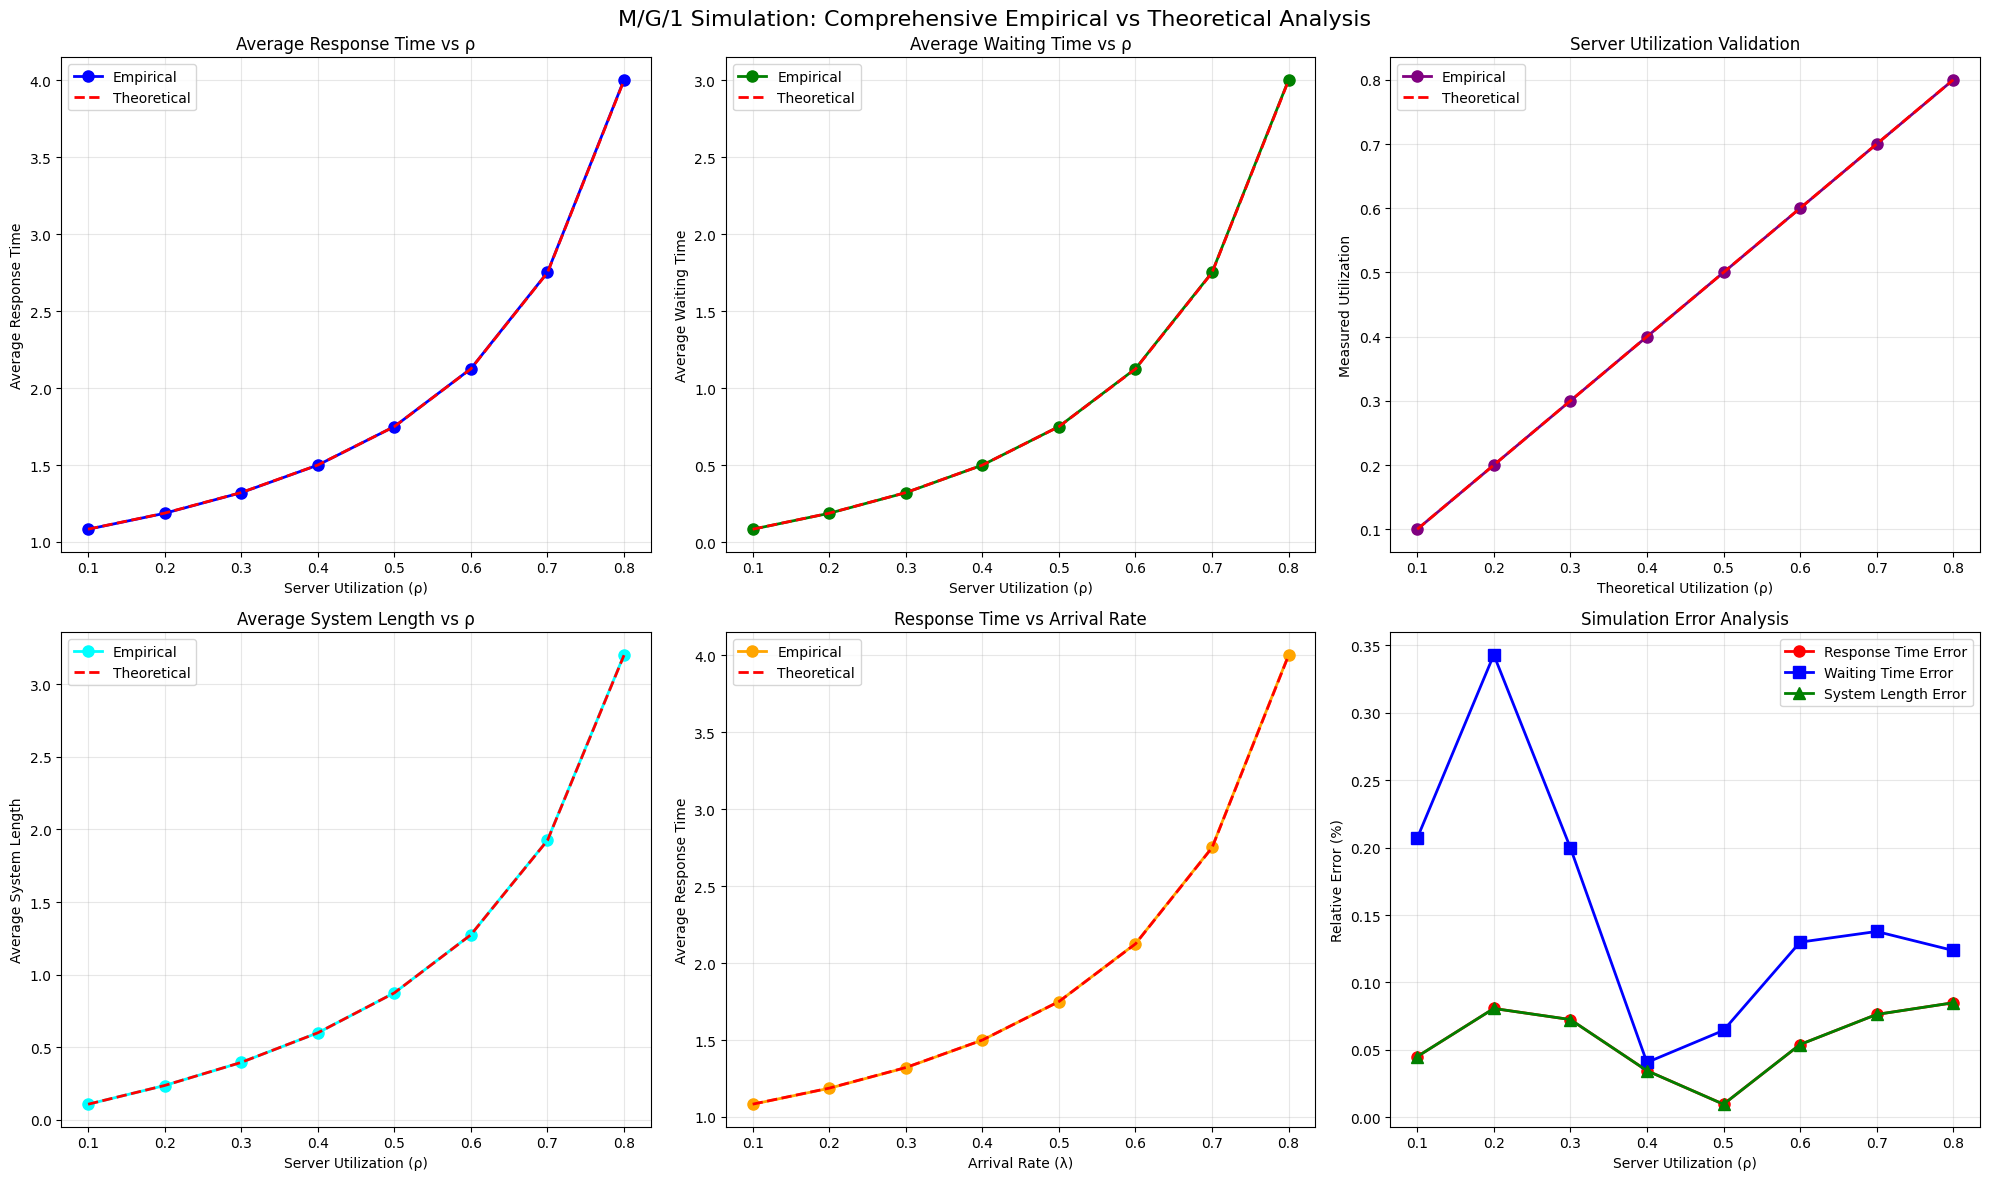


Comparing different Gamma shapes...

Comparing different Gamma shapes: [0.5, 1.0, 2.0, 4.0]


Shape Comparison:   0%|          | 0/4 [00:00<?, ?it/s]


Testing shape = 0.5

Running M/G/1 experiments
Lambda values: [0.1 0.3 0.5 0.7]
μ = 1.0, shape = 0.5, customers = 500000



M/G/1 Experiments:   0%|          | 0/4 [00:00<?, ?it/s]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 18%|█▊        | 87568/500000 [00:00<00:00, 875616.12it/s]

 36%|███▌      | 178595/500000 [00:00<00:00, 895979.28it/s]

 54%|█████▎    | 268193/500000 [00:00<00:00, 888467.60it/s]

 71%|███████▏  | 357048/500000 [00:00<00:00, 833979.76it/s]

100%|██████████| 500000/500000 [00:00<00:00, 853557.35it/s]

M/G/1 Experiments:  25%|██▌       | 1/4 [00:01<00:05,  1.76s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 16%|█▌        | 79189/500000 [00:00<00:00, 791822.79it/s]

 34%|███▍      | 170031/500000 [00:00<00:00, 860388.16it/s]

 52%|█████▏    | 260993/500000 [00:00<00:00, 882843.16it/s]

 71%|███████   | 352682/500000 [00:00<00:00, 896262.40it/s]

100%|██████████| 500000/500000 [00:00<00:00, 886036.20it/s]

M/G/1 Experiments:  50%|█████     | 2/4 [00:03<00:03,  1.70s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 17%|█▋        | 85526/500000 [00:00<00:00, 855218.00it/s]

 34%|███▍      | 171048/500000 [00:00<00:00, 796383.74it/s]

 52%|█████▏    | 261348/500000 [00:00<00:00, 843169.34it/s]

 70%|██████▉   | 348311/500000 [00:00<00:00, 853353.93it/s]

100%|██████████| 500000/500000 [00:00<00:00, 858884.49it/s]

M/G/1 Experiments:  75%|███████▌  | 3/4 [00:05<00:01,  1.69s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 17%|█▋        | 83363/500000 [00:00<00:00, 833559.25it/s]

 35%|███▌      | 175890/500000 [00:00<00:00, 887473.00it/s]

 53%|█████▎    | 266276/500000 [00:00<00:00, 894934.32it/s]

 71%|███████   | 355770/500000 [00:00<00:00, 885748.09it/s]

100%|██████████| 500000/500000 [00:00<00:00, 834040.38it/s]

Shape Comparison:  25%|██▌       | 1/4 [00:06<00:20,  6.82s/it]


Testing shape = 1.0

Running M/G/1 experiments
Lambda values: [0.1 0.3 0.5 0.7]
μ = 1.0, shape = 1.0, customers = 500000



M/G/1 Experiments:   0%|          | 0/4 [00:00<?, ?it/s]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 10%|▉         | 48023/500000 [00:00<00:00, 480183.52it/s]

 19%|█▉        | 96042/500000 [00:00<00:00, 480049.59it/s]

 29%|██▉       | 146284/500000 [00:00<00:00, 490252.65it/s]

 39%|███▉      | 195310/500000 [00:00<00:00, 475031.66it/s]

 49%|████▉     | 245732/500000 [00:00<00:00, 485333.75it/s]

 60%|██████    | 300950/500000 [00:00<00:00, 507746.35it/s]

 71%|███████   | 353697/500000 [00:00<00:00, 514096.39it/s]

 82%|████████▏ | 407619/500000 [00:00<00:00, 522034.41it/s]

100%|██████████| 500000/500000 [00:00<00:00, 506824.35it/s]

M/G/1 Experiments:  25%|██▌       | 1/4 [00:02<00:08,  2.85s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 16%|█▋        | 82287/500000 [00:00<00:00, 822825.66it/s]

 34%|███▍      | 170292/500000 [00:00<00:00, 856457.94it/s]

 51%|█████     | 255938/500000 [00:00<00:00, 815768.51it/s]

 69%|██████▉   | 346467/500000 [00:00<00:00, 850060.65it/s]

100%|██████████| 500000/500000 [00:00<00:00, 864733.27it/s]

M/G/1 Experiments:  50%|█████     | 2/4 [00:04<00:04,  2.13s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 17%|█▋        | 86307/500000 [00:00<00:00, 863007.04it/s]

 35%|███▍      | 173918/500000 [00:00<00:00, 870692.94it/s]

 52%|█████▏    | 262452/500000 [00:00<00:00, 877365.04it/s]

 70%|███████   | 350189/500000 [00:00<00:00, 868569.21it/s]

100%|██████████| 500000/500000 [00:00<00:00, 872896.79it/s]

M/G/1 Experiments:  75%|███████▌  | 3/4 [00:06<00:01,  1.90s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 14%|█▍        | 69144/500000 [00:00<00:00, 691387.91it/s]

 32%|███▏      | 158095/500000 [00:00<00:00, 807895.43it/s]

 50%|████▉     | 248132/500000 [00:00<00:00, 850099.67it/s]

 67%|██████▋   | 336027/500000 [00:00<00:00, 861456.93it/s]

100%|██████████| 500000/500000 [00:00<00:00, 700699.41it/s]

Shape Comparison:  50%|█████     | 2/4 [00:14<00:14,  7.49s/it]


Testing shape = 2.0

Running M/G/1 experiments
Lambda values: [0.1 0.3 0.5 0.7]
μ = 1.0, shape = 2.0, customers = 500000



M/G/1 Experiments:   0%|          | 0/4 [00:00<?, ?it/s]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 16%|█▌        | 79713/500000 [00:00<00:00, 797016.75it/s]

 34%|███▍      | 171383/500000 [00:00<00:00, 867387.05it/s]

 52%|█████▏    | 258941/500000 [00:00<00:00, 871105.56it/s]

 70%|███████   | 350796/500000 [00:00<00:00, 889813.81it/s]

100%|██████████| 500000/500000 [00:00<00:00, 880731.11it/s]

M/G/1 Experiments:  25%|██▌       | 1/4 [00:01<00:05,  1.96s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 17%|█▋        | 82957/500000 [00:00<00:00, 829533.21it/s]

 34%|███▍      | 171897/500000 [00:00<00:00, 864708.79it/s]

 53%|█████▎    | 265296/500000 [00:00<00:00, 896316.99it/s]

 71%|███████   | 354928/500000 [00:00<00:00, 844170.17it/s]

100%|██████████| 500000/500000 [00:00<00:00, 863772.70it/s]

M/G/1 Experiments:  50%|█████     | 2/4 [00:03<00:03,  1.78s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 17%|█▋        | 85372/500000 [00:00<00:00, 853678.07it/s]

 34%|███▍      | 170740/500000 [00:00<00:00, 714846.87it/s]

 49%|████▊     | 243644/500000 [00:00<00:00, 617103.93it/s]

 61%|██████▏   | 306927/500000 [00:00<00:00, 581681.43it/s]

 73%|███████▎  | 365901/500000 [00:00<00:00, 552066.60it/s]

 84%|████████▍ | 421510/500000 [00:00<00:00, 549258.43it/s]

100%|██████████| 500000/500000 [00:00<00:00, 559616.60it/s]

M/G/1 Experiments:  75%|███████▌  | 3/4 [00:05<00:01,  1.88s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

  9%|▉         | 46287/500000 [00:00<00:00, 462832.92it/s]

 19%|█▉        | 94428/500000 [00:00<00:00, 473739.92it/s]

 34%|███▎      | 167577/500000 [00:00<00:00, 591417.19it/s]

 50%|█████     | 250162/500000 [00:00<00:00, 683948.71it/s]

 68%|██████▊   | 337786/500000 [00:00<00:00, 753272.99it/s]

100%|██████████| 500000/500000 [00:00<00:00, 723943.46it/s]

Shape Comparison:  75%|███████▌  | 3/4 [00:22<00:07,  7.82s/it]


Testing shape = 4.0

Running M/G/1 experiments
Lambda values: [0.1 0.3 0.5 0.7]
μ = 1.0, shape = 4.0, customers = 500000



M/G/1 Experiments:   0%|          | 0/4 [00:00<?, ?it/s]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 18%|█▊        | 88721/500000 [00:00<00:00, 887138.93it/s]

 36%|███▌      | 180256/500000 [00:00<00:00, 903713.36it/s]

 55%|█████▍    | 274451/500000 [00:00<00:00, 921148.83it/s]

 73%|███████▎  | 366566/500000 [00:00<00:00, 915223.03it/s]

100%|██████████| 500000/500000 [00:00<00:00, 867681.36it/s]

M/G/1 Experiments:  25%|██▌       | 1/4 [00:01<00:05,  1.68s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 16%|█▋        | 81654/500000 [00:00<00:00, 816478.49it/s]

 34%|███▎      | 168045/500000 [00:00<00:00, 844347.01it/s]

 52%|█████▏    | 261024/500000 [00:00<00:00, 883334.09it/s]

 70%|███████   | 351660/500000 [00:00<00:00, 892400.91it/s]

100%|██████████| 500000/500000 [00:00<00:00, 883684.46it/s]

M/G/1 Experiments:  50%|█████     | 2/4 [00:03<00:03,  1.66s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 16%|█▌        | 77580/500000 [00:00<00:00, 775758.20it/s]

 33%|███▎      | 166019/500000 [00:00<00:00, 839625.34it/s]

 50%|████▉     | 249982/500000 [00:00<00:00, 798132.17it/s]

 67%|██████▋   | 334770/500000 [00:00<00:00, 817158.67it/s]

100%|██████████| 500000/500000 [00:00<00:00, 834432.63it/s]

M/G/1 Experiments:  75%|███████▌  | 3/4 [00:04<00:01,  1.66s/it]

Starting M/G/1 simulation with 500000 customers...
Processing customers...




  0%|          | 0/500000 [00:00<?, ?it/s]

 17%|█▋        | 83306/500000 [00:00<00:00, 833007.17it/s]

 35%|███▌      | 175333/500000 [00:00<00:00, 884302.68it/s]

 53%|█████▎    | 267294/500000 [00:00<00:00, 900401.04it/s]

 71%|███████▏  | 357335/500000 [00:00<00:00, 886191.90it/s]

100%|██████████| 500000/500000 [00:00<00:00, 880080.98it/s]

Shape Comparison: 100%|██████████| 4/4 [00:29<00:00,  7.41s/it]


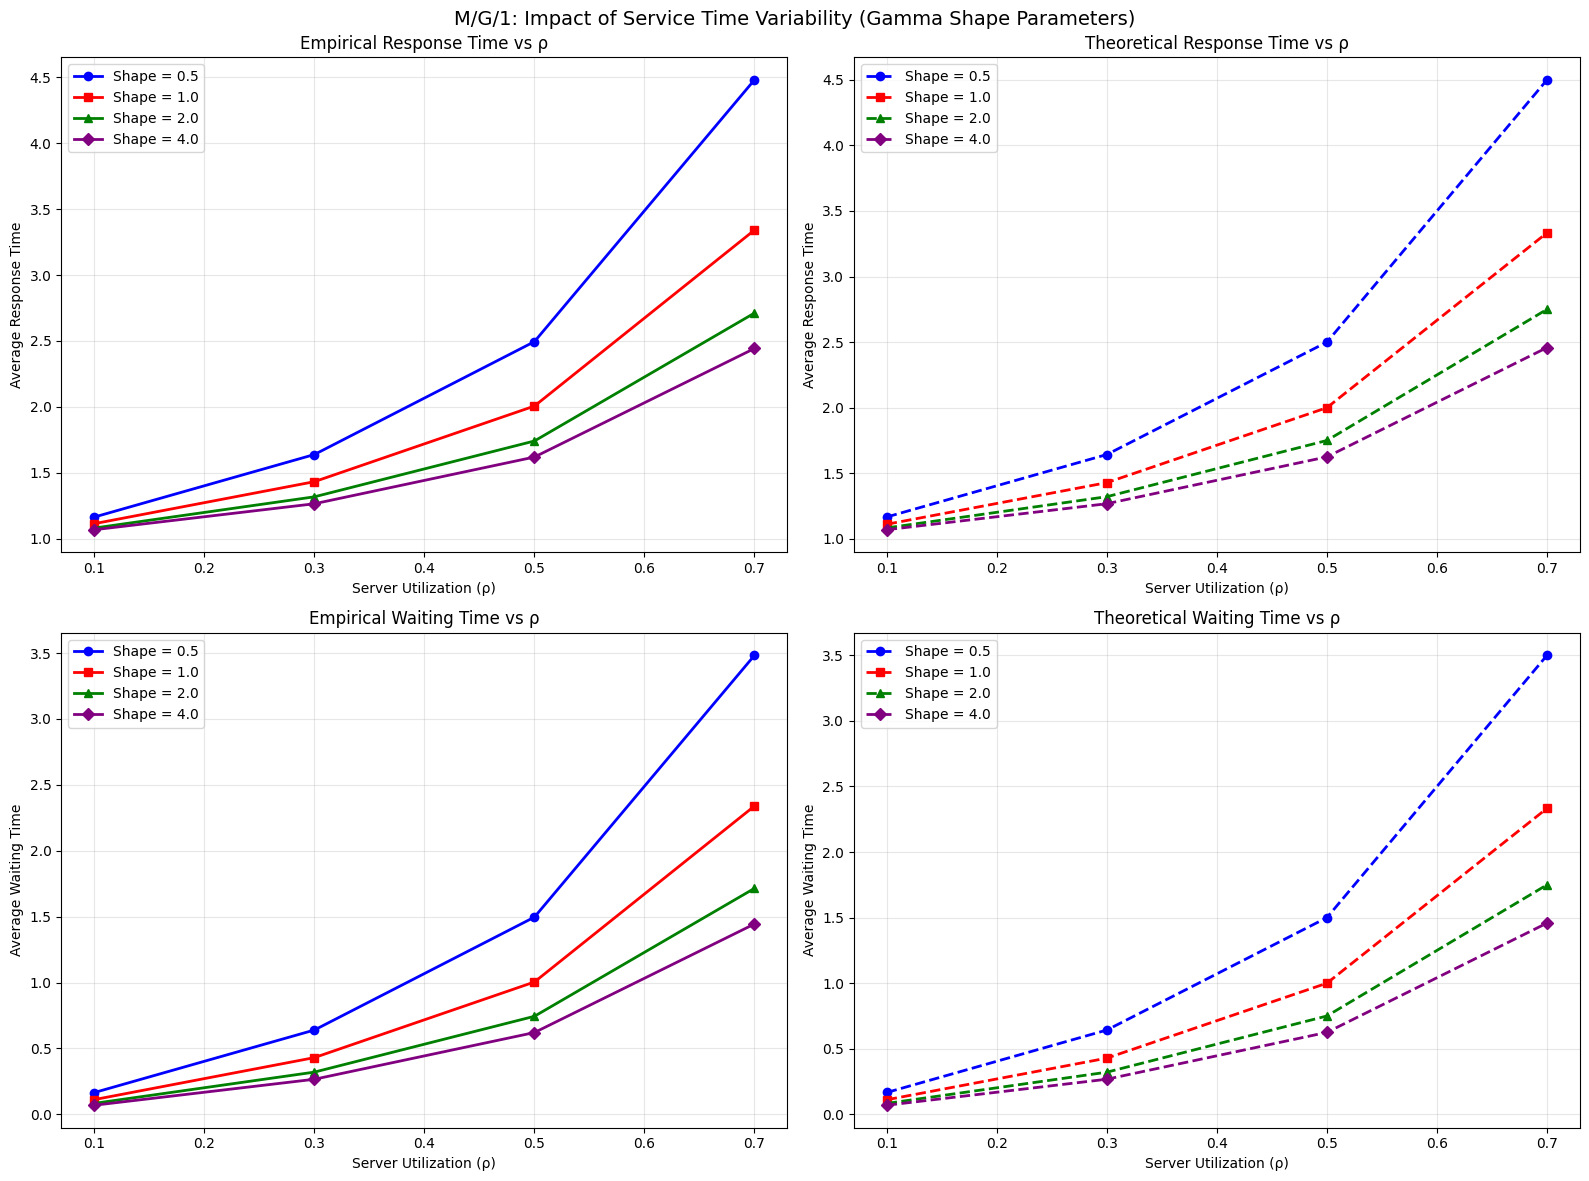

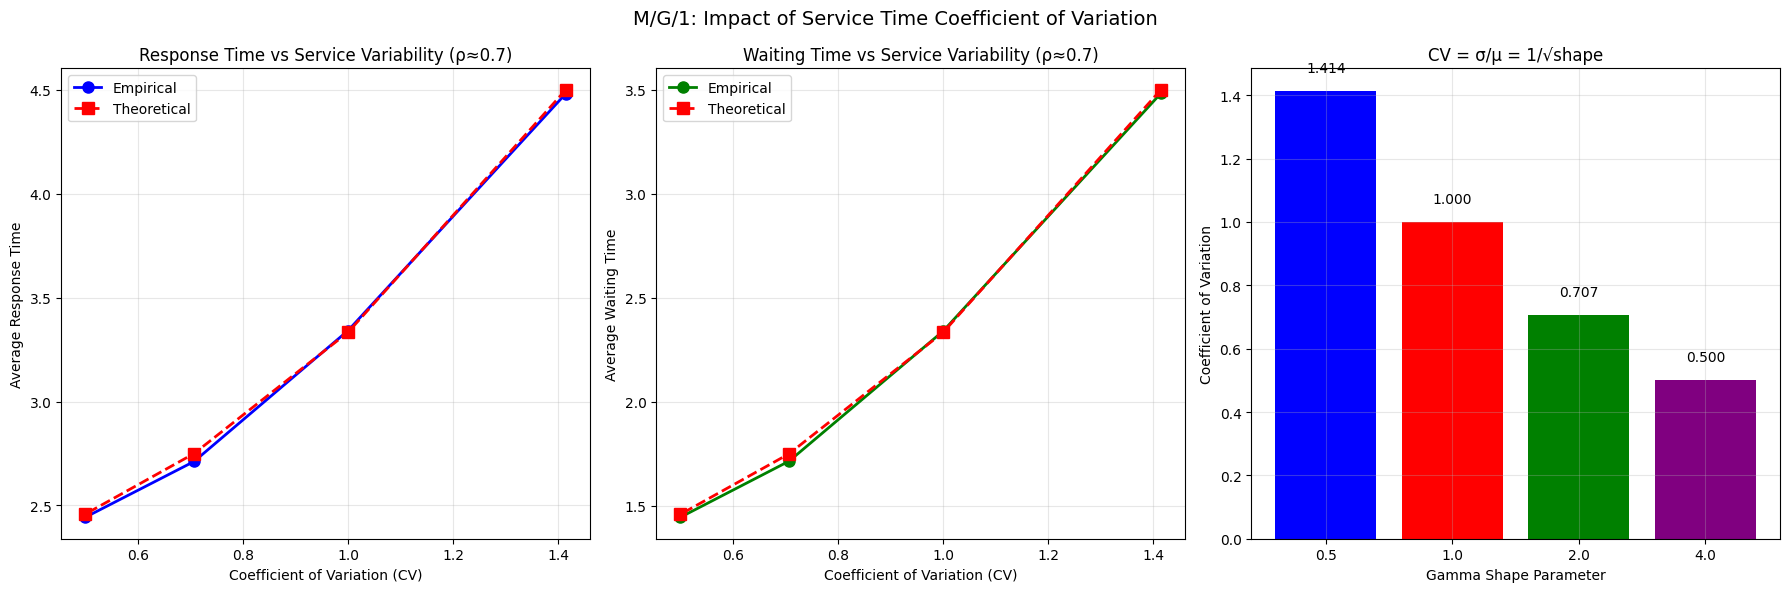


Accuracy Analysis:
--------------------------------------------------------------------------------
λ    ρ      Resp Err%  Wait Err%  Util Err%  Sys Len Err%
--------------------------------------------------------------------------------
0.1  0.10   0.04       0.21       0.01       0.04        
0.2  0.20   0.08       0.34       0.01       0.08        
0.3  0.30   0.07       0.20       0.01       0.07        
0.4  0.40   0.03       0.04       0.01       0.03        
0.5  0.50   0.01       0.06       0.01       0.01        
0.6  0.60   0.05       0.13       0.01       0.05        
0.7  0.70   0.08       0.14       0.01       0.08        
0.8  0.80   0.08       0.12       0.01       0.08        
--------------------------------------------------------------------------------
Average Errors: Resp=0.06%, Wait=0.16%, Util=0.01%, SysLen=0.06%
Max Errors: Resp=0.08%, Wait=0.34%, Util=0.01%, SysLen=0.08%

Running detailed analysis for λ=0.7...
Starting M/G/1 simulation with 200000 customers..

100%|██████████| 200000/200000 [00:00<00:00, 849092.36it/s]


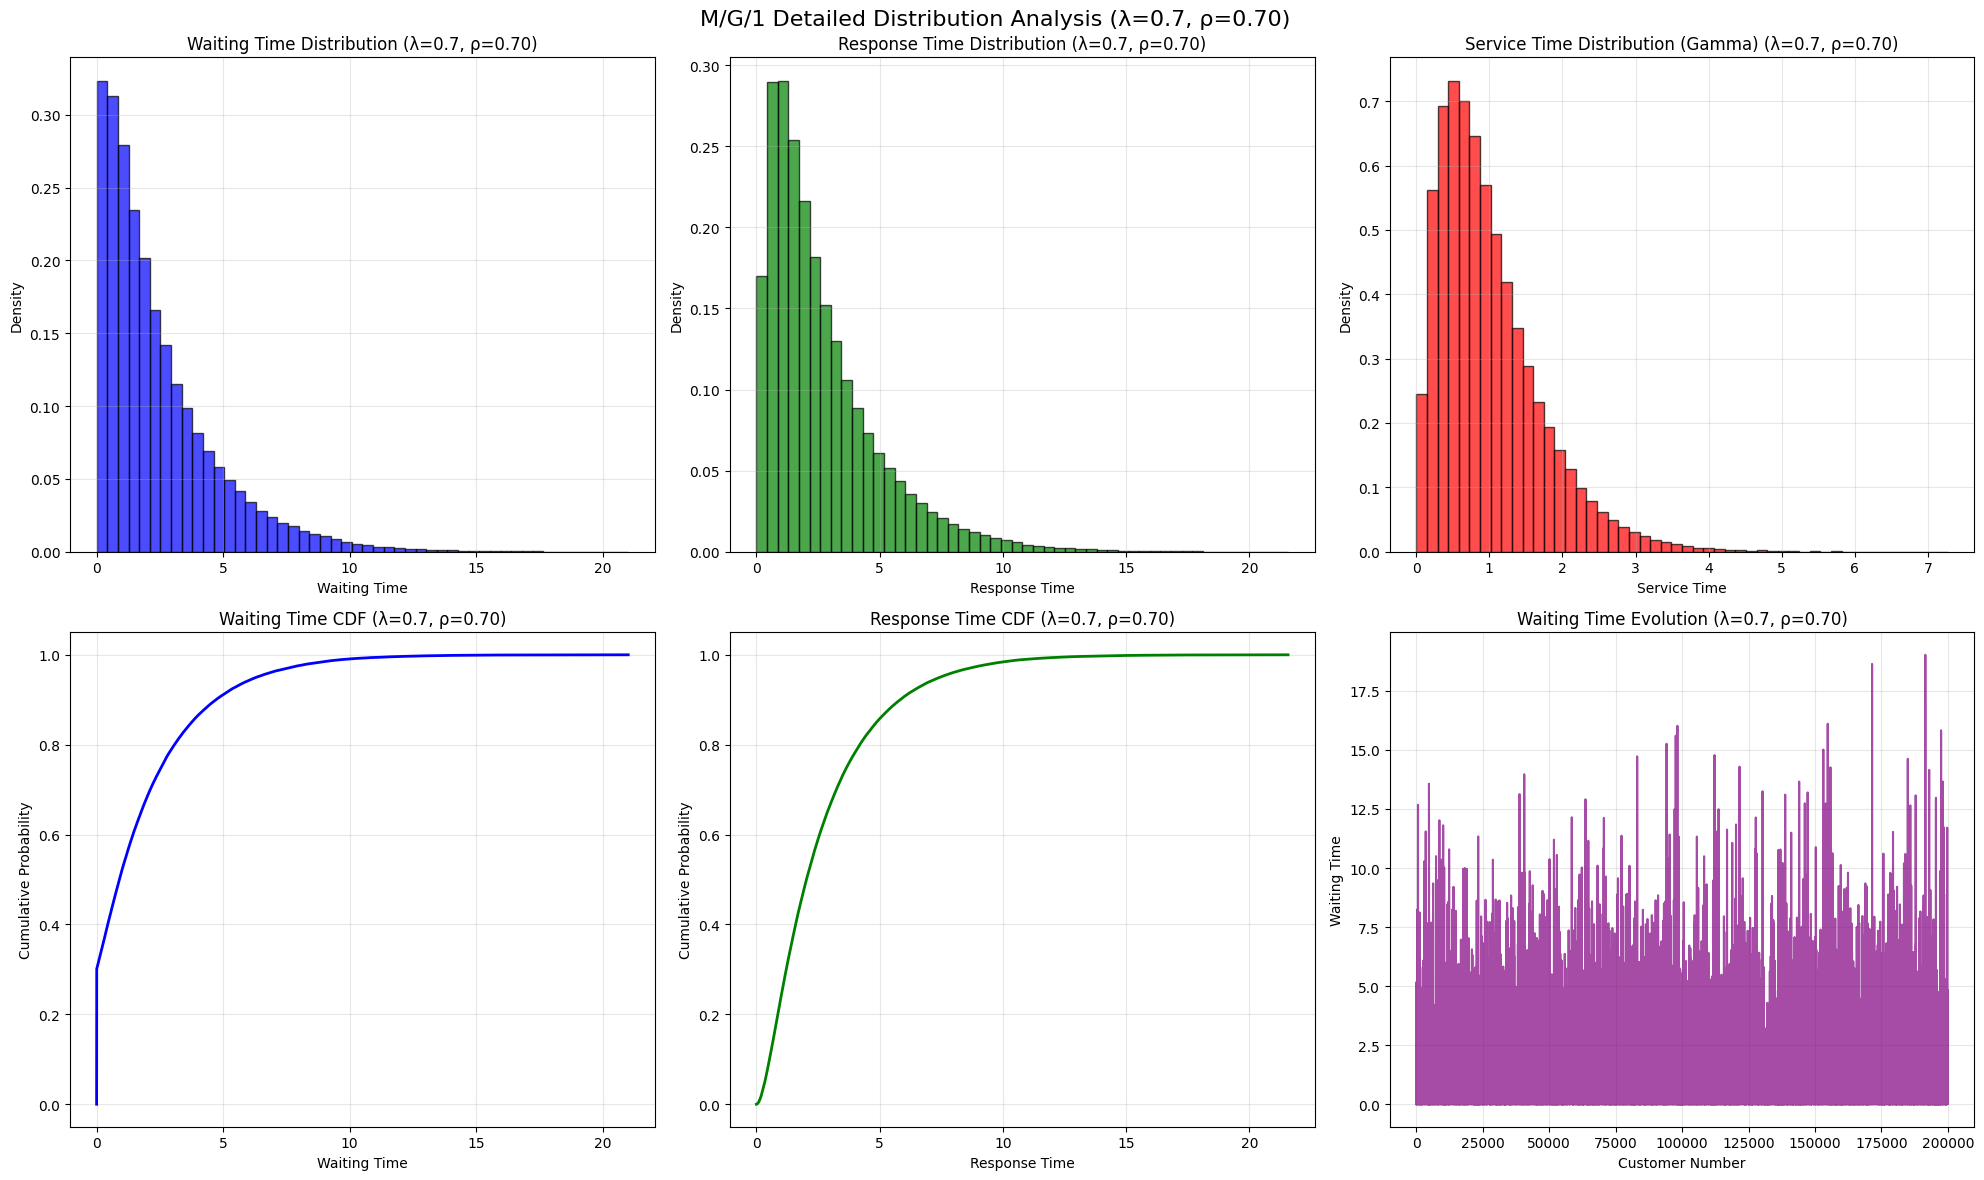


Detailed Metrics for λ=0.7:
- Average waiting time: 1.7150
- Average response time: 2.7164
- Server utilization: 0.7008
- Maximum waiting time: 21.0072
- 95th percentile waiting time: 6.3100
- Standard deviation of waiting times: 2.2419

Theoretical vs Empirical Comparison:
- Waiting time: 1.7500 (theo) vs 1.7150 (emp)
- Response time: 2.7500 (theo) vs 2.7164 (emp)
- System length: 1.9250 (theo) vs 1.9015 (emp)

Shape Comparison Summary:
Tested shapes: [0.5, 1.0, 2.0, 4.0]
Shape 0.5 (CV=1.414): Avg response time = 2.445
Shape 1.0 (CV=1.000): Avg response time = 1.973
Shape 2.0 (CV=0.707): Avg response time = 1.712
Shape 4.0 (CV=0.500): Avg response time = 1.598

Total simulation time: 101.63 seconds
Total customers simulated: 24,200,000

M/G/1 SIMULATION COMPLETE


In [11]:

if __name__ == "__main__":
    main()